In [295]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [296]:
def load_data():
  x_train,y_train , x_test, y_test = np.load("./koke.npy", allow_pickle=True)
    # 入力データの各画素値を0-1の範囲で正規化(学習コストを下げるため)
  X_train = x_train.astype("float32") / 255.0
  X_test  = x_test.astype("float32") / 255.0
  y_train,y_test = y_train.astype("uint8"),y_test.astype("uint8")
  print(type(y_test[0]))
  # to_categorical()にてラベルをone hot vector化
  #y_train =tf.keras.utils.to_categorical(y_train, 15)
  #y_test  = tf.keras.utils.to_categorical(y_test, 15)
  return X_train,  y_train,X_test, y_test

<class 'numpy.uint8'>
(300, 28, 28, 3)
(300, 28, 28, 3)
1
0


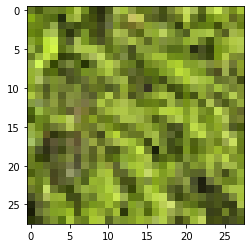

In [297]:

(x_train, y_train, x_test, y_test) = load_data()
print(x_train.shape)
train_images = x_train.reshape((len(x_train),28,28,3))
test_images = x_test.reshape((len(x_test),28,28,3))
print(x_train.shape)
plt.imshow(x_train[0])


print(y_train[0])
print(y_test[0])

In [298]:
class CNN(tf.keras.Model):
  def __init__(self):
    super(CNN,self).__init__()
    self.conv1 = tf.keras.layers.Conv2D(32,(3,3),activation='relu',input_shape=(28,28,3))
    self.maxpooling1 = tf.keras.layers.MaxPool2D((2,2))
    self.conv2 = tf.keras.layers.Conv2D(64,(3,3),activation='relu')
    self.maxpooling2 = tf.keras.layers.MaxPool2D((2,2))
    self.conv3 = tf.keras.layers.Conv2D(64,(3,3),activation='relu')
    self.flatten = tf.keras.layers.Flatten()
    self.dens1 = tf.keras.layers.Dense(64,activation='relu')
    self.dens2 = tf.keras.layers.Dense(15,activation='softmax')
  
  def call(self,x):
    x = self.conv1(x)
    x = self.maxpooling1(x)
    x = self.conv2(x)
    x = self.maxpooling2(x)
    x = self.conv3(x)
    x = self.flatten(x)
    x = self.dens1(x)
    return self.dens2(x)
model = CNN()
print(model.variables)
print(model.trainable_variables)

[]
[]


In [299]:
#損失関数
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
#最適化関数
optimizer = tf.keras.optimizers.Adam()
# 評価指標
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

@tf.function
def train_step(x,y):
  with tf.GradientTape() as tape:
    predictions = model(x)
    loss = loss_object(y,predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy(y, predictions)

@tf.function
def test_step(x, t):
    test_predictions = model(x)
    t_loss = loss_object(t, test_predictions)

    test_loss(t_loss)
    test_accuracy(t, test_predictions)


In [300]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(100).batch(30)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(30)
print(train_ds)
print(x_train.shape)
print(y_train.shape)
#np.reshape(y_train,(-1,len(y_train)))
#y_train = y_train[:,np.newaxis]
print(y_train.shape)
print(model(x_train))
#train_step(x_train,y_train)
EPOCHS = 20
for epoch in range(EPOCHS):
  for images, labels in train_ds:
    #print(images.shape,labels.shape)
    train_step(images, labels) #学習
  for test_images, test_labels in test_ds:
    test_step(test_images, test_labels) #評価

  template = 'Epoch {}, Loss: {}, Accuracy: {}, test-Loss: {}, test-Accuracy:{}'
  print(template.format(epoch + 1,
                          train_loss.result(),
                          train_accuracy.result() * 100,
                          test_loss.result(),
                          test_accuracy.result()*100))



<BatchDataset shapes: ((None, 28, 28, 3), (None,)), types: (tf.float32, tf.uint8)>
(300, 28, 28, 3)
(300,)
(300,)
tf.Tensor(
[[0.06340041 0.0686439  0.06456211 ... 0.06553739 0.06321453 0.07536408]
 [0.06340041 0.0686439  0.06456211 ... 0.06553739 0.06321453 0.07536408]
 [0.06363481 0.06890018 0.06471539 ... 0.06687736 0.0621346  0.07475103]
 ...
 [0.06221802 0.06867193 0.0650848  ... 0.06579567 0.06148076 0.07421985]
 [0.06306871 0.07001889 0.06502783 ... 0.06491082 0.06176773 0.07324743]
 [0.06296959 0.06918977 0.06420017 ... 0.06586143 0.06247662 0.07427216]], shape=(300, 15), dtype=float32)
Epoch 1, Loss: 2.6717395782470703, Accuracy: 13.0, test-Loss: 2.799865961074829, test-Accuracy:6.6666669845581055
Epoch 2, Loss: 2.495680570602417, Accuracy: 15.333333969116211, test-Loss: 2.9876646995544434, test-Accuracy:6.6666669845581055
Epoch 3, Loss: 2.363771915435791, Accuracy: 17.77777862548828, test-Loss: 3.1374123096466064, test-Accuracy:6.6666669845581055
Epoch 4, Loss: 2.284094810485